In [48]:
import math
import numpy as np
from itertools import product, combinations, chain
from operator import sub
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_traj(num_traj):
    t = []
    vol = []
    trajec_num = []

    for i in range(num_traj):
        t_0 = np.random.uniform(2.5, 3.5)
        t.append(t_0)

        candidate_w_1 = 100
        while candidate_w_1 > 2.5:
            candidate_w_1 = np.random.gamma(1, 1.5)
        t.append(t_0 + candidate_w_1 + 0.5)

        w_2 = np.random.uniform(4, 9)
        t.append(t_0 + candidate_w_1 + 0.5 + w_2)

        v_peak = np.random.uniform(7, 11)
        vol.extend([3, v_peak, 6])

        trajec_num.extend([i, i, i])
    
    df = np.array([t, vol, trajec_num])
    return(df)


In [3]:
def get_y(traj, x):
    m_1 = (traj[1,1] - traj[1,0]) / (traj[0,1] - traj[0,0]) # slope of first line seg
    b_1 = traj[1,1] - (m_1 * traj[0,1]) # y-int of first line seg

    m_2 = (traj[1,2] - traj[1,1]) / (traj[0,2] - traj[0,1]) # slope of second line seg
    b_2 = traj[1,2] - (m_2 * traj[0,2]) # y-int of second line seg

    y = []
    for i in range(len(x)):
        if x[i] <= traj[0, 1]:
            y_i = (m_1 * x[i]) + b_1
        else:
            y_i = (m_2 * x[i]) + b_2
        
        y.append(y_i)
    
    return(y)

In [4]:
def sample_traj(traj, num_samples):
    x = np.random.uniform(traj[0, 0],traj[0, 2], size = num_samples)

    y = get_y(traj, x)

    sampled_pts = np.array([x, y])

    return(sampled_pts)

In [207]:
def compute_var_coeff(traj, sampled_pts):
    breakpoint_ = traj[0,1]
    sum_minus = 0
    num_minus = 0
    sum_plus = 0
    num_plus = 0
    for x_i in sampled_pts[0]:
        if x_i <= breakpoint_:
            sum_minus += x_i
            num_minus += 1
        else:
            sum_plus += x_i
            num_plus += 1

    if num_minus != 0:
        mean_minus = sum_minus / num_minus
    
    if num_plus != 0:
        mean_plus = sum_plus / num_plus

    D_1 = 0
    D_2 = 0
    for x_i in sampled_pts[0]:
        if x_i <= breakpoint_:
            D_1 += (x_i - mean_minus) ** 2
        else:
            D_2 += (x_i - mean_plus) ** 2
    if D_1 == 0:
        return D_2
    if D_2 == 0:
        return D_1
    
    L = (D_1 + D_2) / (D_1 * D_2)

    return(L)

In [130]:
def sum_to_n(n):
    b, mid, e = [0], list(range(1, n)), [n]
    splits = (d for i in range(n) for d in combinations(mid, i)) 
    return (list(map(sub, chain(s, e), chain(b, s))) for s in splits)

In [212]:
# thank you google AI
def piecewise_linear(x, x0, y0, k1, k2):
    """
    - x0: breakpoint location
    - y0: y-value at the breakpoint
    - k1: slope of the first segment
    - k2: slope of the second segment
    """
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0 - k1*x0, 
                                        lambda x: k2*x + y0 - k2*x0])

In [213]:
num_points = 50
num_process = 5
traj = generate_traj(1)
sampled_pts = sample_traj(traj, num_points) 
error_x = np.random.normal(0, 0.1, num_points)
error_y = np.random.normal(0, 0.1, num_points)
sampled_pts = np.array([sampled_pts[0] + error_x, sampled_pts[1] + error_y])

#point_combos = np.array(list(combinations(sampled_pts.T, 5)))

row_mask = sampled_pts.T[:, 0] < traj[0,1]

below_break = sampled_pts.T[row_mask]

above_break = sampled_pts.T[~row_mask]

pairs = []
for sub in range(2, num_process - 1):
    pair = [sub, num_process - sub]
    pairs.append(pair)

all_combos = []

for pair in pairs:
    combinations_above = list(combinations(below_break, pair[0]))
    combinations_below = list(combinations(above_break, pair[1]))
    combinationsab = list(product(combinations_above, combinations_below))
    all_combos = all_combos + [combo[0] + combo[1] for combo in combinationsab]

all_combos = np.array(all_combos)

minimum = 100000
for combo in all_combos:
    L = compute_var_coeff(traj, combo.T)
    if L < minimum:
        minimum = L
        points = combo

In [215]:
params, covariance = optimize.curve_fit(piecewise_linear, points.T[0], points.T[1])

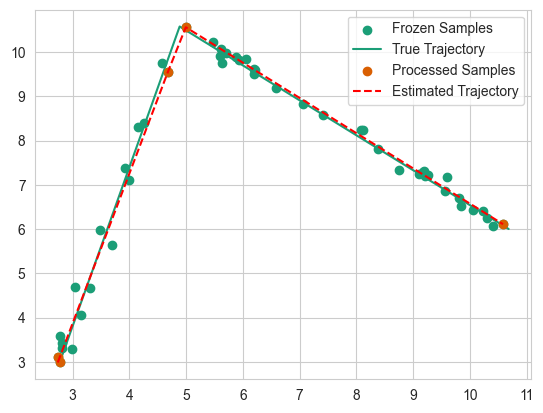

In [219]:
sns.set_style("whitegrid")
sns.set_palette("Dark2")
plt.scatter(sampled_pts[0], sampled_pts[1], zorder = 2, label = "Frozen Samples")
plt.plot(traj[0], traj[1], zorder = 1, label = "True Trajectory")
plt.scatter(points.T[0], points.T[1], zorder = 3, label = "Processed Samples")
plt.plot(points.T[0], piecewise_linear(points.T[0], *params), zorder = 4, color='red', label='Estimated Trajectory', ls = "dashed")
plt.legend()